# Pipeline Fun
The purpose of this notebook is to play around with scikit-learn pipelines.

In [46]:
# data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)

# ML imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Import Data
Data come from [Kaggle: Flight Price Prediction](https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction?resource=download).

In [7]:
df_raw = pd.read_csv('./data/Clean_Dataset.csv')
print(df_raw.shape)
df_raw.head()

(300153, 12)


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [54]:
df_raw['stops'].value_counts()
df_raw['stops_int'] = df_raw['stops'].map({'zero': 0, 'one': 1, 'two_or_more': 2})
df_raw['stops_int'].value_counts()

stops_int
1    250863
0     36004
2     13286
Name: count, dtype: int64

In [56]:
df_raw['class'].value_counts()
df_raw['is_business'] = 1.0 * (df_raw['class'] == 'Business')
df_raw['is_business'].value_counts()

is_business
0.0    206666
1.0     93487
Name: count, dtype: int64

# Simplest Case: Just Price, Duration, Days Left

In [57]:
simple_columns = [
    'price',
    'stops_int',
    'is_business',
    'duration',
    'days_left',
]
df_simple = df_raw[simple_columns].copy()
df_simple.head()

,price,stops_int,is_business,duration,days_left
0,5953,0,0.0,2.17,1
1,5953,0,0.0,2.33,1
2,5956,0,0.0,2.17,1
3,5955,0,0.0,2.25,1
4,5955,0,0.0,2.33,1


## Data Visualization

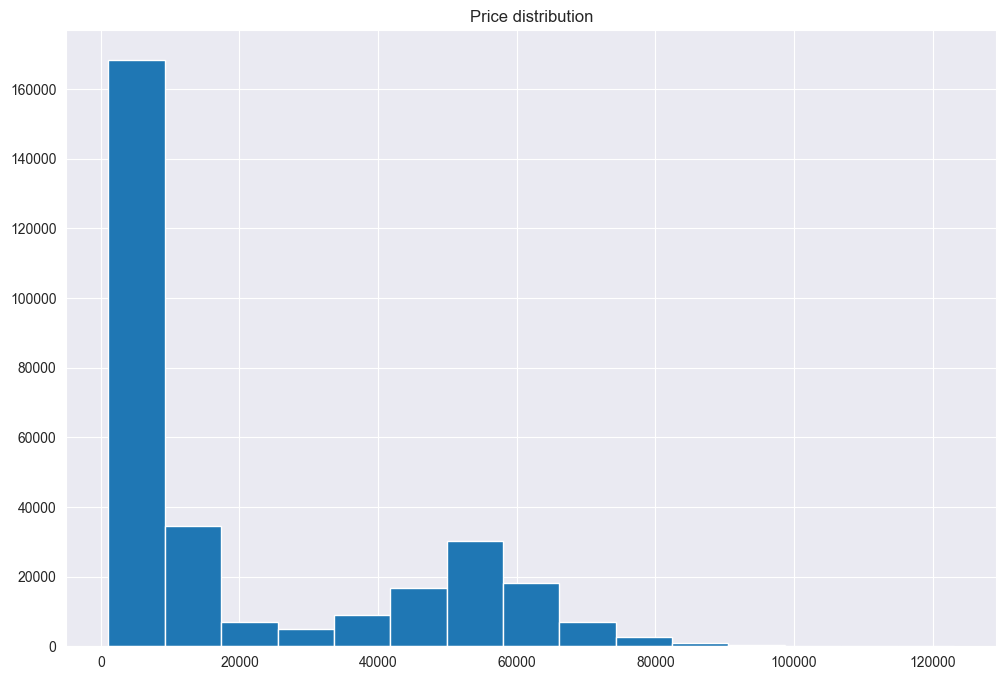

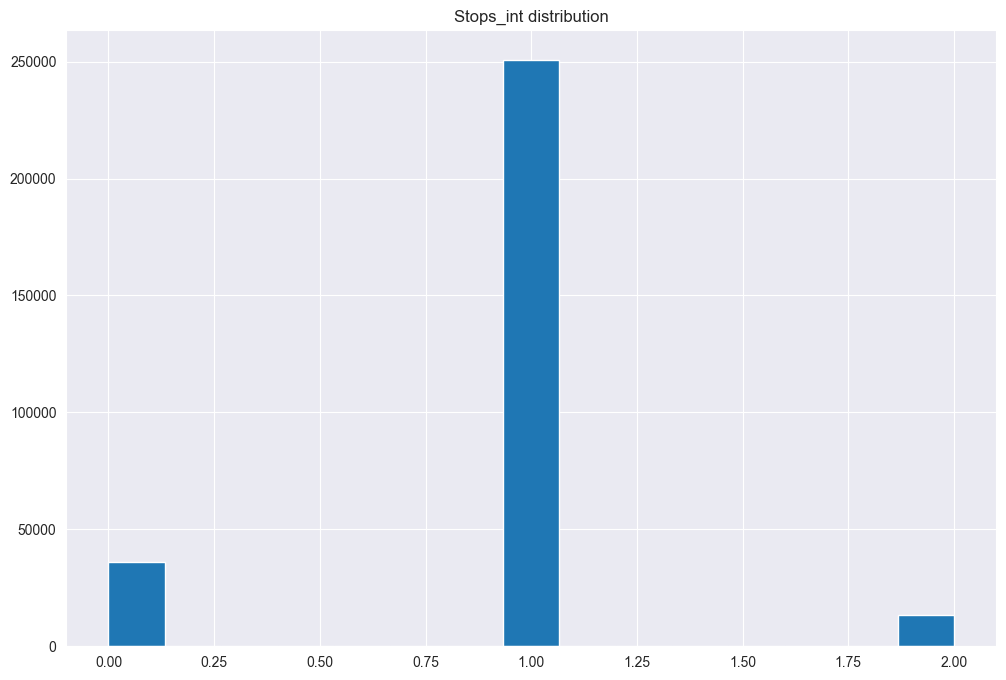

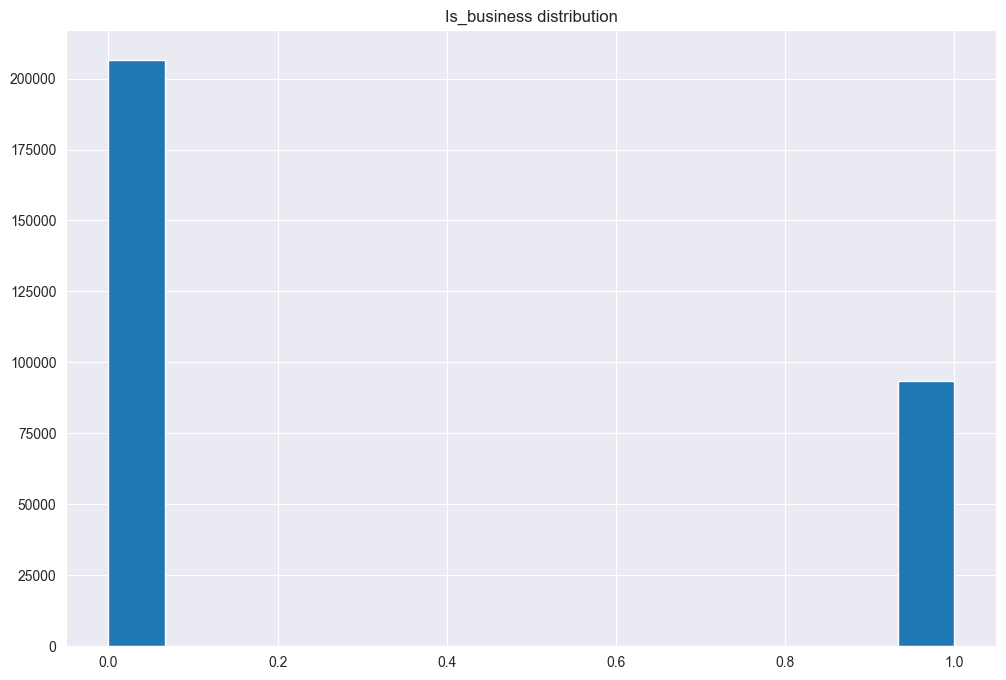

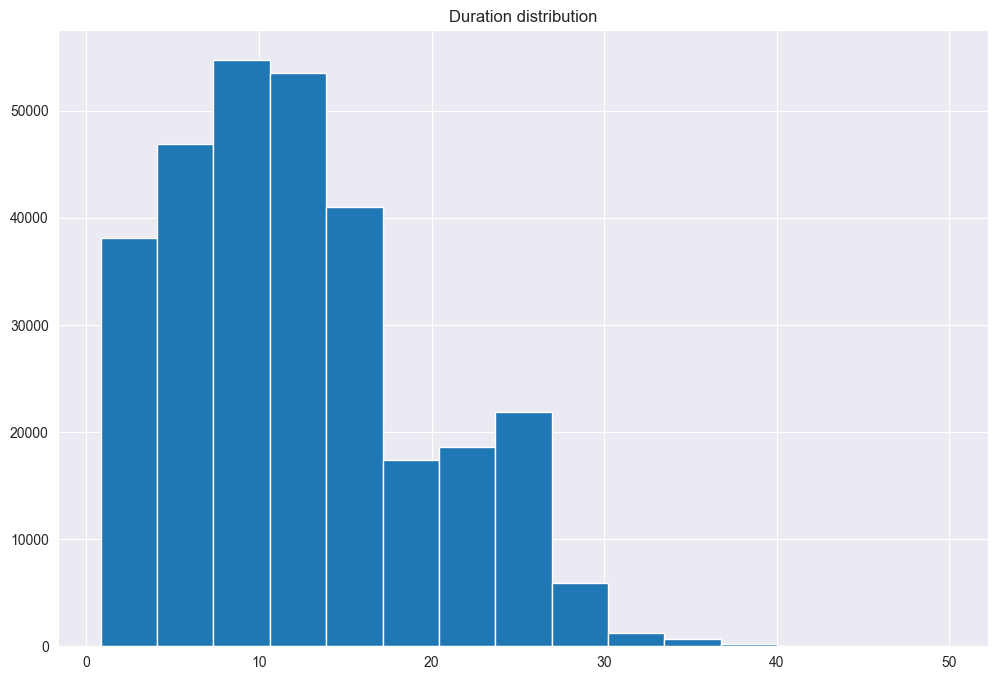

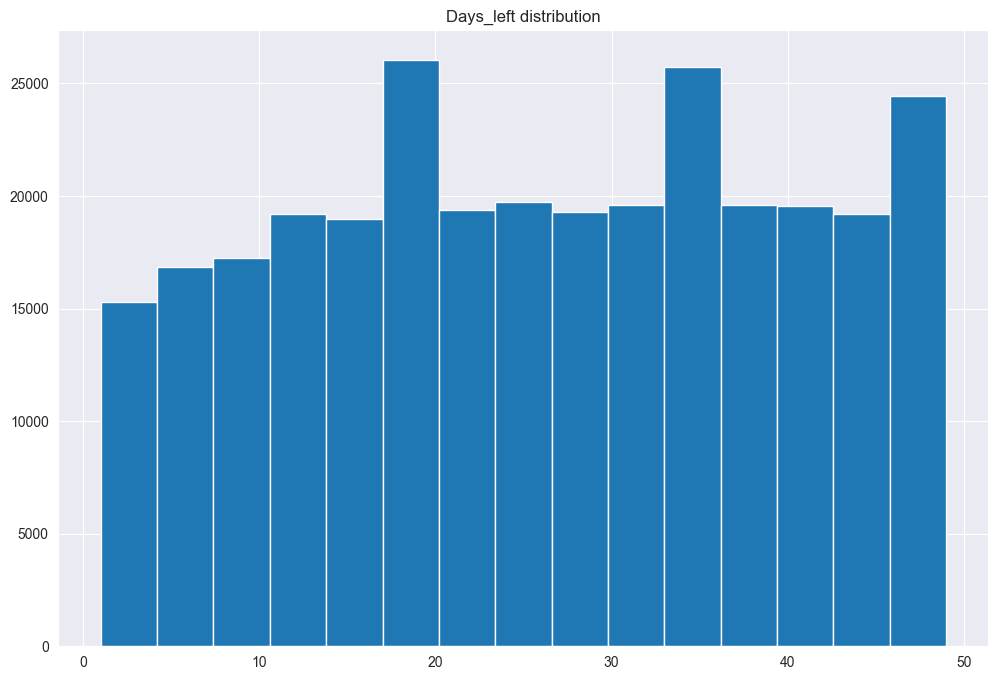

In [58]:
for col in df_simple.columns:
    plt.hist(df_simple[col], bins=15)
    plt.title(f'{col} Distribution'.capitalize())
    plt.show()

## Fit Model

In [59]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    df_simple.drop(columns=['price']),
    df_simple['price'],
    test_size=0.2,
    random_state=0
)
df_simple_fitted = pd.concat([X_test, y_test], axis=1)
df_simple_fitted.head()
df_simple_fitted.describe()

,stops_int,is_business,duration,days_left,price
count,60031.000000,60031.000000,60031.000000,60031.000000,60031.000000
mean,0.923540,0.308207,12.247385,25.941347,20718.075511
std,0.400047,0.461757,7.229688,13.535300,22612.540188
min,0.000000,0.000000,0.830000,1.000000,1105.000000
25%,1.000000,0.000000,6.750000,15.000000,4755.000000
50%,1.000000,0.000000,11.250000,26.000000,7412.000000
75%,1.000000,1.000000,16.170000,38.000000,42457.000000
max,2.000000,1.000000,47.750000,49.000000,114705.000000


In [61]:
"""
A sklearn pipeline can be used like any other estimator,
for example with the .fit(), .predict(), and .score() methods
"""
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('linear regression', LinearRegression())
])
pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear regression', LinearRegression())])

In [62]:
pipe_trained = pipe.fit(X_train, y_train)
pipe_predictions = pipe_trained.predict(X_test)
np.sqrt(mean_squared_error(pipe_predictions, y_test))

7103.84045495602

## Naive Model (Mean)

In [63]:
mean_prediction_value = y_test.mean()
mean_predictions = mean_prediction_value * np.ones(y_test.shape)
np.sqrt(mean_squared_error(mean_predictions, y_test))

22612.351846311067

## Just Linear Regression, No Scaler
Scaling does not affect linear regression, because the fitted scaler itself is a linear operation:

$$ X^{scaled} = (X^{raw} - \mu_X) / \sigma_X $$

and therefore, for a fitted coefficient $\hat{\beta}$,

$$ \hat{\beta} X^{raw} =  \sigma_X ( \hat{\beta} + \mu_X ) X^{scaled} $$

In [64]:
lr_trained = LinearRegression().fit(X_train, y_train)
lr_predictions = lr_trained.predict(X_test)
np.sqrt(mean_squared_error(lr_predictions, y_test))

7103.84045495602

## L2 (Ridge) Regression

In [74]:
pipe_ridge = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('ridge regression', Ridge(alpha=1.0))
])
pipe_ridge

Pipeline(steps=[('scaler', StandardScaler()), ('ridge regression', Ridge())])

In [75]:
pipe_ridge_fitted = pipe_ridge.fit(X_train, y_train)
pipe_ridge_predictions = pipe_ridge_fitted.predict(X_test)
np.sqrt(mean_squared_error(pipe_ridge_predictions, y_test))

7103.840293369177

## L2 (Ridge) w/o Scaler

In [76]:
ridge_fitted = Ridge(alpha=1.0).fit(X_train, y_train)
ridge_predictions = ridge_fitted.predict(X_test)
np.sqrt(mean_squared_error(ridge_predictions, y_test))

7103.839915902109

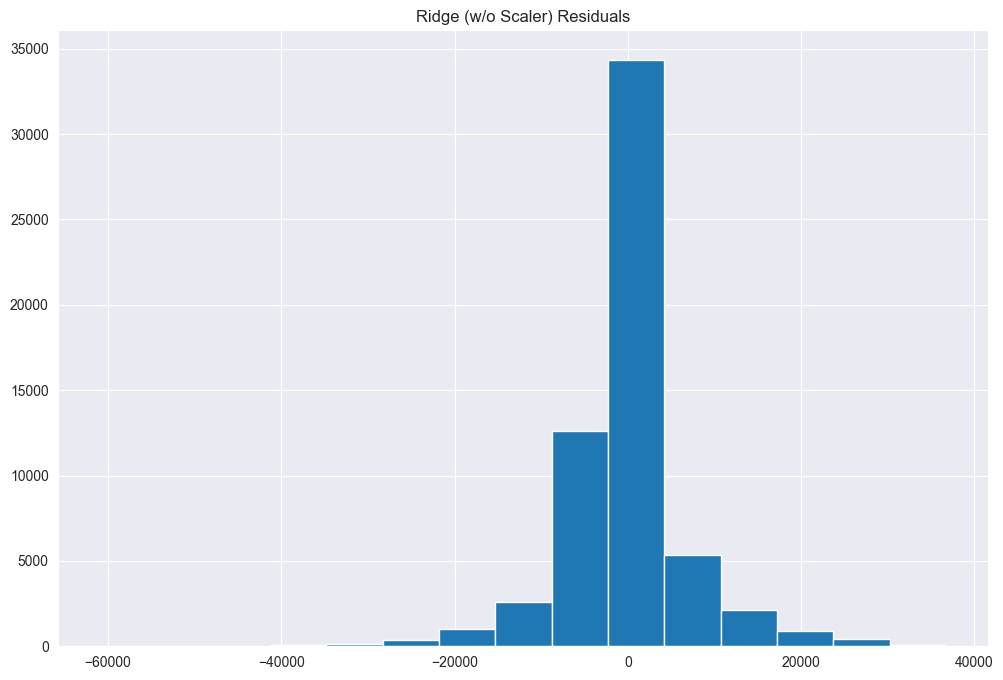

In [77]:
plt.hist(ridge_predictions - y_test, bins=15)
plt.title('Ridge (w/o Scaler) Residuals')
plt.show()

## Inspect Scaler

In [67]:
scaler_trained = StandardScaler().fit(X_train)
scaler_predictions = scaler_trained.transform(X_test)

In [68]:
scaler_predictions[:4]

array([[ 0.18986775, -0.67385275,  2.12816003, -1.10711182],
       [ 0.18986775,  1.48400375, -0.73712615,  1.25148727],
       [-2.32510491, -0.67385275, -1.387315  , -0.88599316],
       [-2.32510491, -0.67385275, -1.30656349,  0.95666238]])

In [69]:
X_test[:4]

,stops_int,is_business,duration,days_left
44712,1,0.0,27.50,11
233644,1,1.0,6.92,43
121467,0,0.0,2.25,14
185846,0,0.0,2.83,39
